# [PSSC 6월 세미나] TDA implementation tutorial : MNIST Classification.
###           강연자 : 이성헌 (Postech, MINDS 대학원생)


### Abstract

  TDA는 데이터의 위상적인 특징을 추출하여 데이터를 분석하는 분야입니다.
예를 들어서, 손 글씨 이미지 데이터를 인식한다고 할 때 기존의 방식은 이미지 데이터를 그저 픽셀의 모임으로 인식해야 했습니다.
그렇지만 TDA는 손 글씨 이미지 데이터가 내재적으로 함의하고 있는 기하학적 특징을 추출해서 인식하도록 합니다.

 사람이 서로 다른 사람이 쓴 숫자 '8'을 읽는다고 할 때, 두 글씨체가 아무리 다르더라도 '2개의 구멍이 위 아래로 위치하고 있다'는 기하학적인 공통점을 통해서 같은 숫자임을 인식합니다. 
이와 마찬가지로 TDA는 조금 더 사람의 추상적 사고에 가까운 머신러닝을 추구합니다. 


이 튜토리얼에서는 MNIST 데이터셋과 Giotto-tda 라이브러리를 이용해 위와 같은 숫자 분류 문제를 간단히 구현해보려고 합니다.
먼저 간단하게 Giotto-tda 라이브러리의 사용법을 배웁니다.
다음으로 MNIST 데이터로부터 위상적인 특징을 추출해내는 알고리즘을 만들어 데이터를 전처리합니다.
마지막으로 기존에 분류 문제에 사용되던 머신러닝 기법을 적용해 이 작업이 잘 작동하는지 살펴봅니다.


MNIST 데이터셋은 하나에 28*28 = 784개의 변수를 가지고 있습니다. 
그러나 TDA는 이들 데이터 자체를 사용하는 것이 아닌, 이들의 위상적 특징만을 추출하기에 사용되는 변수의 개수가 훨씬 적습니다.
TDA를 이용한 머신러닝은 이처럼 동일한 데이터로부터 훨씬 적은 변수만을 사용하여 거의 동일한 성능을 기대할 수 있습니다.


이를 통해, 지난 두 달간 김근수 님이 PSSC 월말 세미나에서 발표하셨던 TDA의 이론들이 실제 데이터 분석에 어떻게 이용되는지 이해할 수 있을 것입니다.


# 1. Review : Topological Data Analysis Framework



**Topological Data Analysis (TDA)** 는 Algebraic Topology의 테크닉을 이용해서 데이터의 모양에 대한 위상적$\cdot$기하학적 정보를 추출하고 연구하는 분야입니다.

TDA의 Main Framework은 다음과 같이 구성됩니다.

##### ***Step 1***.
 주어진 Point cloud $X$에 대해, *filtration*이라 불리는 과정을 반복적으로 적용해 기하학적인 구조 (Simplicial Complex)를 만듭니다. 주로 *Vietoris-Rips complex*가 사용됩니다.

#####***Step 2***.
 Simplicial complex로부터 *Persistent Homology*를 만듭니다. Persistent homology는 simplicial complex가 가지는 위상적 정보(connected component의 수,loop의 수, void의 수)를 포함하고 있습니다.

#####***Step 3***.
 위에서 구한 Topological feature들이 filtration이 계속되면서 언제 탄생(birth)하고 사라지는지(death)를 Persistent Barcode나 Persistent diagram 형태로 요약합니다.

In [1]:
from IPython.display import Image
Image(url='https://eric-bunch.github.io/images/noisy_circle_simplexes_and_persistent_homology.png')
#Figure reference : Topological Data Analysis and Persistent Homology by Eric Bunch https://eric-bunch.github.io/blog/topological-data-analysis-and-persistent-homology

In [2]:
from IPython.display import Image
Image(url='https://giotto-ai.github.io/gtda-docs/0.4.0/_images/persistent_homology_0d.gif')
# Figure reference: towardsdatascience.com/persistent-homology-with-examples-1974d4b9c3d0.

`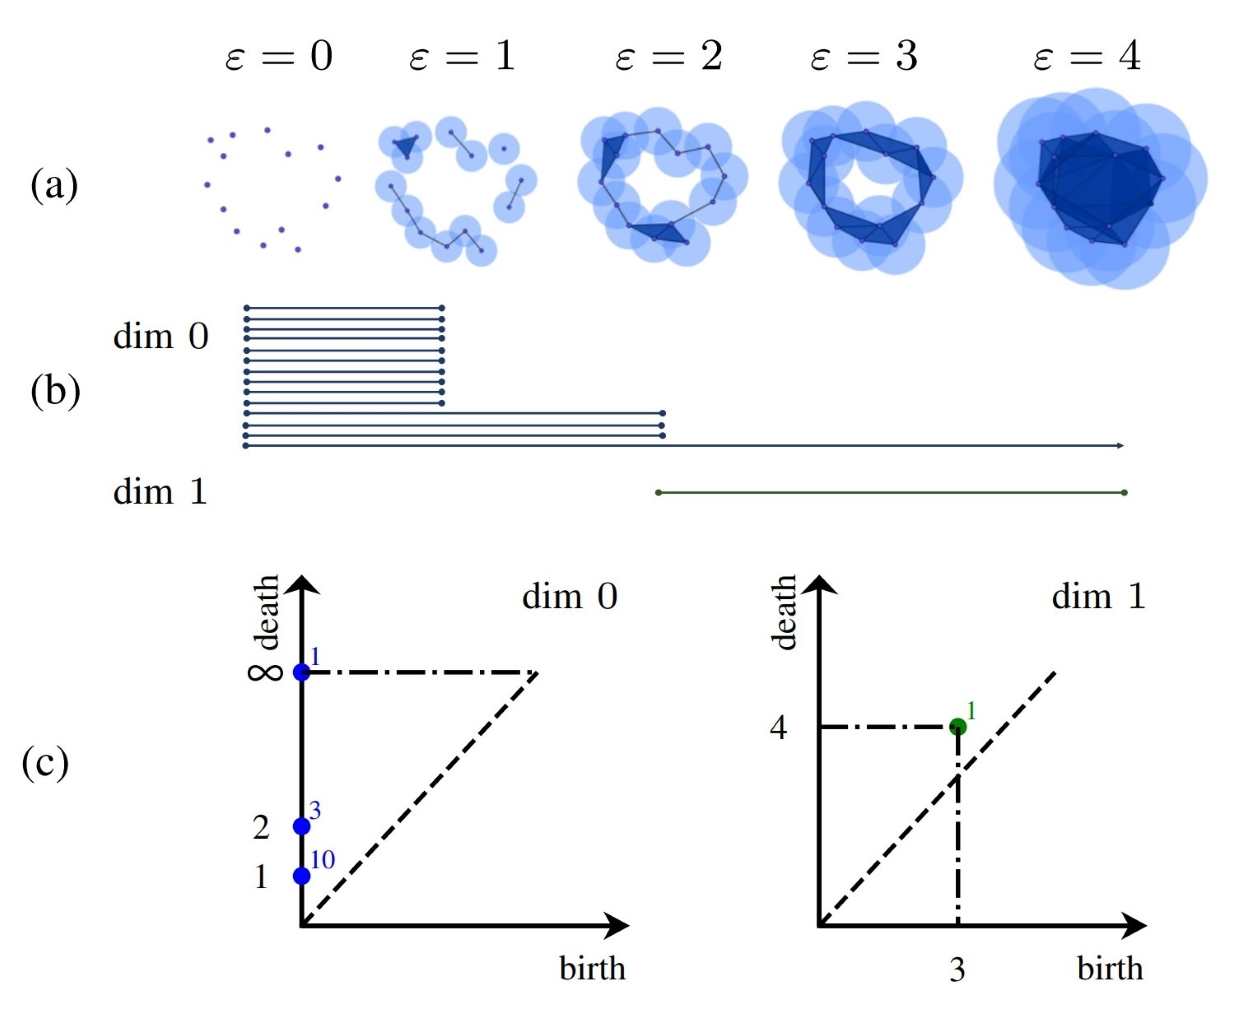


Figure (1) : TDA Framework
Reference : A Topological "Reading" Lesson: Classification MNIST using TDA, Adelie Garin


---




\\
# 2. Introduction to Giotto-tda

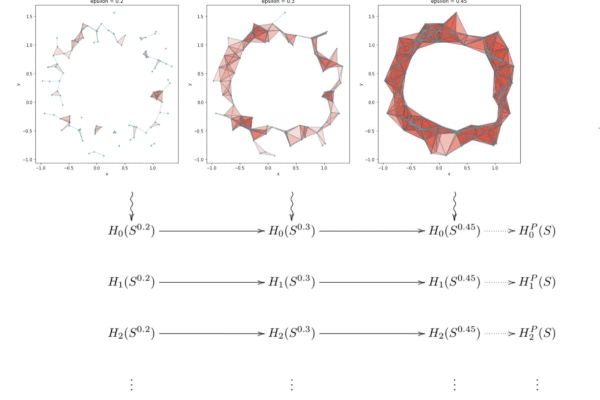

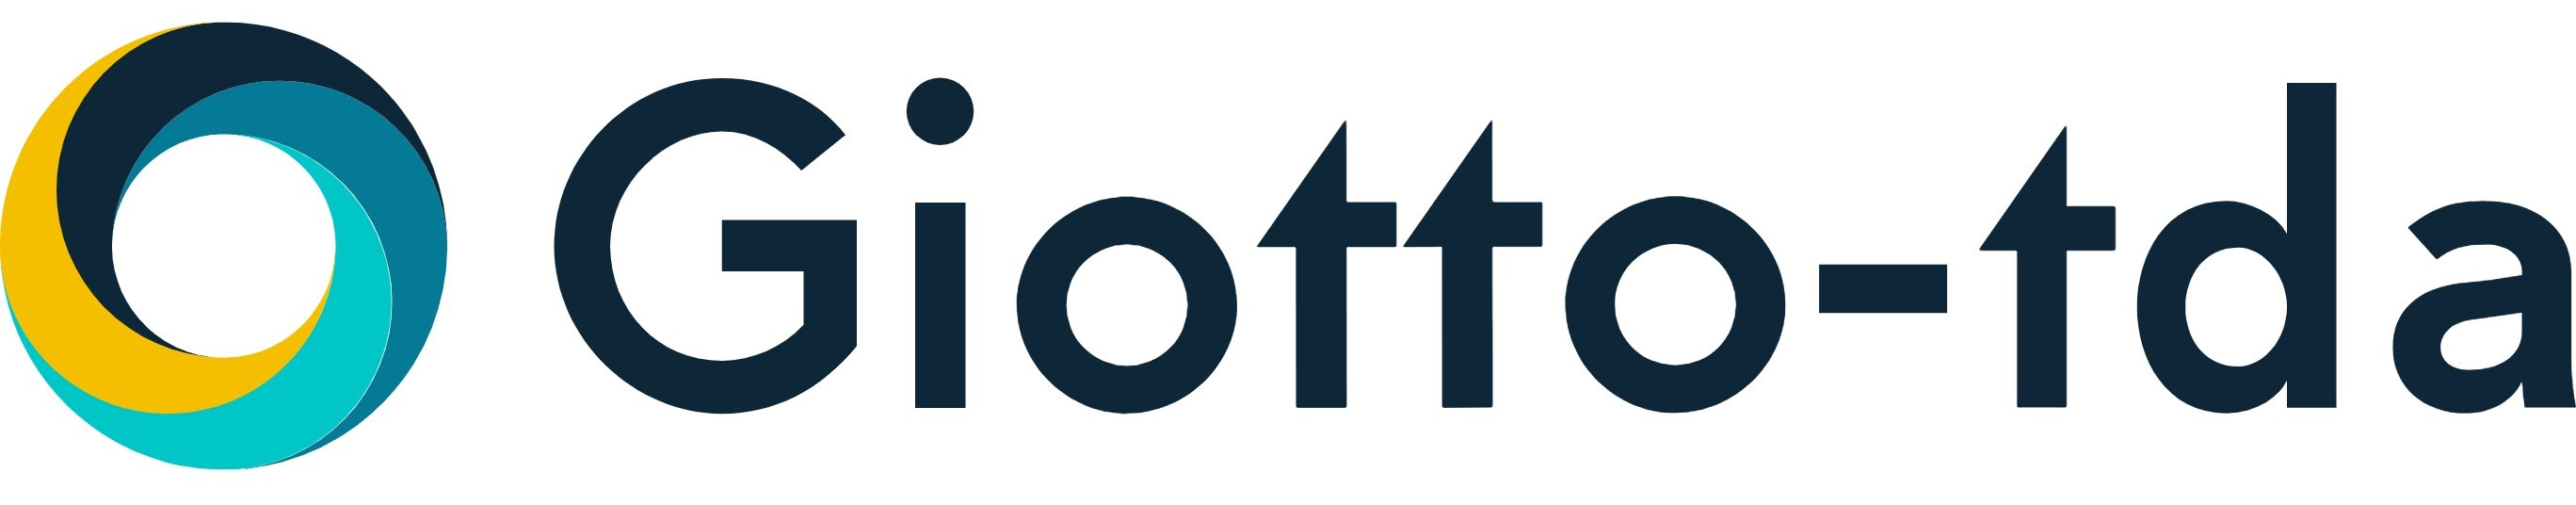

Giotto-tda는 scikit-learn 기반의 TDA machine learning을 위한 오픈 소스 라이브러리입니다. 

Giotto-tda에는 다음과 같은 기능들이 포함되어 있습니다.
1. Point cloud를 plotting 하는 기능이 있습니다. 특히 멋진 점은, plotting된 이미지는 확대, 축소, 회전 등 상호작용이 가능하다는 점입니다.

2. Vietoris-Rips complex, Persistent Homology 등 TDA를 하는데 필요한 중요한 도구들을 계산해줍니다.

3. TDA stream line을 하나로 뭉쳐 쉽게 많은 량의 데이터를 처리할 수 있습니다.

먼저 아래의 명령어를 입력해 Giotto-tda를 Google colab에 설치합니다.

개인 Jupyter Notebook을 사용하시는 분은 Anaconda prompt에서

`!python -m pip install -U giotto-tda`

를 입력하여 설치할 수 있습니다.



In [ ]:
!pip uninstall imgaug        # 애석하게도 Google colab이 너무 높은 버전의 imgaug 라이브러리를 장착하고 있어서 giotto-tda 설치시 에러가 납니다. 
!pip install imgaug==0.2.5    # giotto-tda를 사용하기에 알맞은 버전의 imgaug를 설치합니다.
!python -m pip install -U giotto-tda    # 이 명령어를 통해서 giotto-tda를 설치할 수 있습니다.

이제 `Giotto-tda` 설치가 완료되었습니다.

이제 간단한 예제로 Giotto-tda 가 어떻게 사용되는지 살펴봅시다.

먼저 예제를 불러오기 위해 미리 첨부해드린 'generate_datasets.py' 모듈을 불러옵시다.



In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('generate_datasets.py','wb').write(src)

위 방법이 잘 되지 않으시는 분은 아래의 코드를 입력하셔서 사용하시면 됩니다.

In [ ]:
#generate_datasets.py
import numpy as np
from pathlib import Path


def make_point_clouds(n_samples_per_shape: int, n_points: int, noise: float):
    """Make point clouds for circles, spheres, and tori with random noise.
    """
    circle_point_clouds = [
        np.asarray(
            [
                [np.sin(t) + noise * (np.random.rand(1)[0] - 0.5), np.cos(t) + noise * (np.random.rand(1)[0] - 0.5), 0]
                for t in range((n_points ** 2))
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label circles with 0
    circle_labels = np.zeros(n_samples_per_shape)

    sphere_point_clouds = [
        np.asarray(
            [
                [
                    np.cos(s) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.cos(s) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label spheres with 1
    sphere_labels = np.ones(n_samples_per_shape)

    torus_point_clouds = [
        np.asarray(
            [
                [
                    (2 + np.cos(s)) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    (2 + np.cos(s)) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label tori with 2
    torus_labels = 2 * np.ones(n_samples_per_shape)

    point_clouds = np.concatenate((circle_point_clouds, sphere_point_clouds, torus_point_clouds))
    labels = np.concatenate((circle_labels, sphere_labels, torus_labels))

    return point_clouds, labels


def make_gravitational_waves(
    path_to_data: Path,
    n_signals: int = 30,
    downsample_factor: int = 2,
    r_min: float = 0.075,
    r_max: float = 0.65,
    n_snr_values: int = 10,
        ):
    def padrand(V, n, kr):
        cut = np.random.randint(n)
        rand1 = np.random.randn(cut)
        rand2 = np.random.randn(n - cut)
        out = np.concatenate((rand1 * kr, V, rand2 * kr))
        return out

    Rcoef = np.linspace(r_min, r_max, n_snr_values)
    Npad = 500  # number of padding points on either side of the vector
    gw = np.load(path_to_data / "gravitational_wave_signals.npy")
    Norig = len(gw["data"][0])
    Ndat = len(gw["signal_present"])
    N = int(Norig / downsample_factor)

    ncoeff = []
    Rcoeflist = []

    for j in range(n_signals):
        ncoeff.append(10 ** (-19) * (1 / Rcoef[j % n_snr_values]))
        Rcoeflist.append(Rcoef[j % n_snr_values])

    noisy_signals = []
    gw_signals = []
    k = 0
    labels = np.zeros(n_signals)

    for j in range(n_signals):
        signal = gw["data"][j % Ndat][range(0, Norig, downsample_factor)]
        sigp = int((np.random.randn() < 0))
        noise = ncoeff[j] * np.random.randn(N)
        labels[j] = sigp
        if sigp == 1:
            rawsig = padrand(signal + noise, Npad, ncoeff[j])
            if k == 0:
                k = 1
        else:
            rawsig = padrand(noise, Npad, ncoeff[j])
        noisy_signals.append(rawsig.copy())
        gw_signals.append(signal)

    return noisy_signals, gw_signals, labels


\\

`make_point_cluds` 는 '원(Circle), 구(Spheres), 토러스(Torus)' 모양의 point cloud 예제를 생성하는 도구입니다.

`n_samples_per_shape=10` 의 의미는 각각의 모양 당 몇 개의 sample을 만들지 선택하는 것입니다. 10으로 선택했으므로, 원 10개 구 10개 토러스 10개 총 30개의 sample이 생성될 것입니다.

`n_points=20` 의 의미는 각각의 곡면을 결정하는 parameter에 20개만큼 sampling 하겠다는 의미입니다. 예를 들어서, 3차원 상에서 구면은 $(\cos{s}\cos{t},\cos{s}\sin{t},\sin{s})$ 로 결정되므로, parameter $t$와 $s$를 각각 1부터 20까지 대입해 총 400개의 구면 위의 점을 sampling 합니다.

`noise=0.5` 의 의미는 각각의 sampling된 점들마다 noise를 주는 요소입니다.






In [ ]:
from generate_datasets import make_point_clouds

point_clouds_basic, labels_basic = make_point_clouds(n_samples_per_shape=10
                                                     , n_points=20
                                                     , noise=0.5)
point_clouds_basic.shape, labels_basic.shape

\\

Giotto-tda에는 point cloud를 plotting하는 기능이 포함되어 있습니다.
이 기능은 단순히 모양을 plotting 하는것 뿐만 아니라, 각 점마다 커서를 가져다 대면 좌표를 띄워주거나 도형을 확대,회전하는 등의 상호작용도 가능합니다.

\\


In [ ]:
from gtda.plotting import plot_point_cloud

# Circle
plot_point_cloud(point_clouds_basic[0])

In [ ]:
# Sphere

plot_point_cloud(point_clouds_basic[10])

In [ ]:
# Torus

plot_point_cloud(point_clouds_basic[-1])

----
\\


`Giotto-tda` 에는 TDA를 하기 위한 기본적인 도구들이 포함되어 있습니다.

위 처럼 Point cloud를 얻었을 때, 이들로부터 

***Step 1***.
Vietoris-Rips complex를 구성하고 

***Step 2***.
여기에서 Persistent homology를 계산하고

***Step 3***
이 정보로부터 Persistent diagram을 그려주는

과정을 쉽게 수행할 수 있습니다.

\\

In [ ]:
from gtda.homology import VietorisRipsPersistence
# 'VietorisRipsPersistence'는 Point cloud에 Vietoris-Rips complex를 구성했을 때 Persistence 정보를 얻는 기능입니다.

In [ ]:
# 구하고자 하는 Homology dimension을 지정해줍니다. 우리의 데이터는 3D 데이터이므로, 2nd homology까지를 지정합니다.

homology_dimensions = [0, 1, 2]  

#  0th-homology = the number of connected components
#  1th-homology = the number of holes
#  2nd-homology = the number of voids

In [ ]:
# Step 1 to 3 can be accomplished by the following code.
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)

diagrams_basic = persistence.fit_transform(point_clouds_basic)

\\

위 코드를 실행하면 우리가 만든 400개의 Point cloud들로부터 Vietoris-Rips complex를 구성해서 얻은 Persistence 정보를 `diagrams_basic`에 저장해둡니다.

\\

\\

이제 앞서 얻은 Persistence 정보로부터 Persistent diagram을 그려봅시다.

\\

In [ ]:
# Plotting Persistent diagram
from gtda.plotting import plot_diagram

In [ ]:
# Circle
plot_diagram(diagrams_basic[0])

Persistent diagram에서 대각선 근처의 정보는 Birth time과 Death time이 거의 같기 때문에 Noise에 가까운 정보입니다.

Circle의 Persistent diagram에는 하나의 1st homology에 대한 Persistence가 두드러집니다. 이것의 의미는 Point cloud가 구멍이 하나인 Manifold로부터 얻어진 데이터라는 것입니다.

\\

In [ ]:
# Sphere
plot_diagram(diagrams_basic[10])

마찬가지로, Sphere의 Persistent diagram에서 하나의 2nd-homology에 대한 Persistence가 두드러집니다. 

그러므로, 이 Point cloud는 void가 하나인 Manifold (Sphere)로부터 얻어진 데이터임을 의미합니다.

\\

In [ ]:
# Torus
plot_diagram(diagrams_basic[-1])

Torus로부터 얻어진 Point cloud의 Persistence 정보는 Circle이나 Sphere의 경우와 다른 모양을 띄는 것을 알 수 있습니다.

Persistent diagram을 살펴보는 이유는, 만약 두 대상이 비슷하다면, 그것의 Persistence diagram도 비슷할 것이라는 ***Stability theorem*** 때문입니다.

그러므로 TDA에서는 두 데이터가 위상적으로 얼마나 비슷한가를 두 데이터의 Persistence diagram이 얼마나 비슷한가로 측정합니다.

---
\\


# 3. Data Preprocessing through TDA: Implement on MNIST

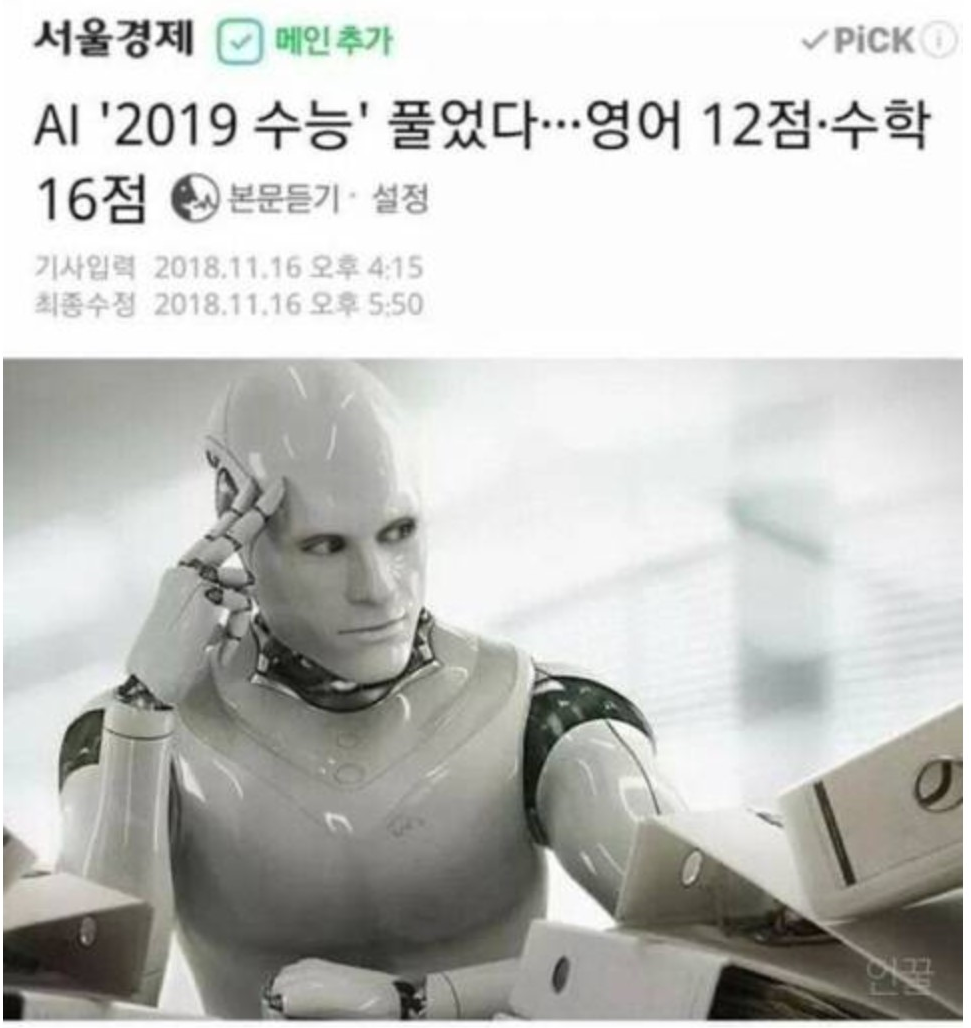

MNIST dataset은 7만개의 숫자 손 글씨 데이터입니다.


각각의 손 글씨는 28*28=784개의 픽셀로 이루어져 있습니다.


MNIST dataset을 다룰 때엔, 각 픽셀을 feature로 생각하면 너무 feature가 많기 때문에 어떻게 중요한 feature들만 선택해서 학습시킬 것인지가 관건입니다.


이런 문제를 **Feature selection**이라고 합니다. 

기존의 머신러닝 방법은 이미지 픽셀 자체가 가지는 데이터로부터 Feature를 선택합니다. 

그러나 TDA에서는 이미지 픽셀들이 내재적으로 가지고 있는 ***Topological한 feature***를 추출해서 사용합니다.

\\

사람이 숫자 데이터를 인식할 때, 픽셀 단위로 인식하지 않습니다.

비록 글씨체가 많이 다른 사람이 쓴 숫자들이라고 할지라도, 그 글씨들이 공유하는 기하학적 특징을 인식해서 같은 숫자임을 알아차립니다.

이런 점에서 보았을 때, Topological한 feature를 학습시키는 것은 오히려 사람에 더 가까운 인공지능을 만드는 것이라 할 수 있겠습니다.

\\

먼저 Sklearn에서 MNIST 데이터를 불러옵시다.
(데이터를 7만개나 불러오기 때문에 처음에 시간이 조금 걸립니다.)

In [7]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1, as_frame = False, return_X_y=True)

print(f"X shape: {X.shape}, y shape: {y.shape}") # 잘 불러왔다면, X는 7만개의 784 사이즈 데이터가, y는 70000개의 데이터가 있다고 print될 것입니다.

X shape: (70000, 784), y shape: (70000,)


`plot_heatmap` 은 데이터의 2D 데이터의 heat map (gray-scale image)를 띄워줍니다.
역시 giotto-tda 의 plotting 기능은 상호작용이 가능합니다.


예제로 숫자 8을 불러와봅시다.

In [ ]:
import numpy as np
from gtda.plotting import plot_heatmap

im8_idx = np.flatnonzero(y=="8")[0]    # label이 8인 데이터 y=="8" 중에서 가장 첫 번째 데이터의 index를 불러옵니다.
img8 = X[im8_idx].reshape(28,28)        # 데이터 X에서 index가 위 조건을 만족하는 것을 28*28 shape로 불러옵니다.
                                       # 이 데이터는 28*28 행렬에 각 component마다 gray-scale 값이 부여된 형태일 것입니다.
plot_heatmap(img8)                     # 앞서 불러온 데이터를 heatmap으로 plotting 합니다.


\\


7만개의 데이터가 너무 많아 학습시간이 너무 오래걸리니 7천개의 데이터만 사용해봅시다.

\\

In [ ]:
from sklearn.model_selection import train_test_split

train_size, test_size = 7000, 1000                    

# Reshape to (n_samples, n_pixels_x, n_pixels_y)
X = X.reshape((-1, 28, 28))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=666
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

\\

이제 각 숫자 이미지들로부터 Topological feature들을 추출하는 작업을 시작합시다.

먼저, 각 Gray-scale 이미지들을 흰색 혹은 검정색으로 Binarize하는 것이 다루는 데에 합리적일 것입니다. 

Giotto-tda의 `Binarizer`를 이용해 이 작업을 할 수 있습니다.

\\

In [ ]:
from gtda.images import Binarizer

# Training set에서 숫자 8을 하나 꺼내서 Binarize해봅시다.
im8_idx = np.flatnonzero(y_train =="8")[-1]
im8 = X_train[im8_idx][None, :, :]

binarizer = Binarizer(threshold=0.4)
im8_binarized = binarizer.fit_transform(im8)

binarizer.plot(im8_binarized)

\\

이제 이렇게 Binarize된 데이터에 Filtration을 적용해봅시다.

여기서는 ***Radial Filtration***을 적용할 것입니다.

Radial Filtration은 다음과 같은 방법으로 filtration을 진행합니다.

1. 이미지 데이터에서 Center $c$를 원하는 곳으로 잡습니다.

2. 점 $c$를 중심으로 반지름 $r$을 늘려가며, 같은 반지름 위에 놓이는 픽셀들마다 같은 filtration에 놓습니다.

3. 이런 방식으로 하나의 Complex $\left\{K_r\right\}_{r=0}^\infty$를 얻습니다.

Giotto-tda의 `RadialFiltration`은 center를 선택해 특정 데이터에 위와 같은 과정을 수행해줍니다.

\\

In [ ]:
from gtda.images import RadialFiltration

radial_filtration = RadialFiltration(center=np.array([20, 6]))    #여기서는 Center가 (20,6)으로 선택되었습니다.
im8_filtration = radial_filtration.fit_transform(im8_binarized)   #위에서 띄웠던 Binarized된 8에 이 Filtration을 적용해봅시다.

radial_filtration.plot(im8_filtration, colorscale="jet")

이제 Filtration을 얻었으니, Persistent Homology를 계산해 Persistent diagram을 얻을 차례입니다.

픽셀 데이터를 다룰 때엔 사실 Simplicial Complex가 아닌 Cubical Complex라는 개념이 더 적합하기 때문에, `CubicalPersistence`를 이용해 Persistence 정보를 얻습니다.

(Simplicial complex는 삼각형을 기본단위로 생각했다면, Cubical complex는 사각형을 기본단위로 삼는다는 점만 다를 뿐, 나머지 개념은 동일합니다.)

\\

In [ ]:
from gtda.homology import CubicalPersistence

cubical_persistence = CubicalPersistence(n_jobs=-1)
im8_cubical = cubical_persistence.fit_transform(im8_filtration)

cubical_persistence.plot(im8_cubical)

위 그림에서 보이다시피, 1st homology H1에 해당하는 Persistent한 정보가 2개 등장합니다. 이는, 8이 구멍이 2개가 있음을 의미합니다.

이제 위 Persistent diagram을 하나의 Feature로 이용하기 위해 Vectorization하는 과정이 필요합니다. 

이를 위해서는 Amplitude 라는 개념이 사용됩니다.

주어진 Persistent diagram $X$의 Amplitude는 $X$와 empty diagram $\Delta$ 와의 차이로 정의됩니다.

empty diagram은 Persistence 정보가 없는 diagram으로 대각선만 가진 diagram입니다.

이를 계산하는 방법만 소개하자면,

1. 먼저 Persistence diagram $X$를 Homology dimension에 따라 따로 생각한다.

2. 각각의 Dimension에서 Persistence (Death - Birth)가 가장 큰 점을 구한다. 이 점은 대각선에서 가장 멀리있는 점이다.

3. 이 점과 대각선 사이의 거리를 구한다. 이 점의 좌표가 $(b,d)$ 라면, $$\frac{\sqrt{2}}{2}(d-b)$$ 로 구해진다.

\\
***
\\
***주의!***

 실제로 손으로 계산한 Amplitude와 Giotto-tda로 구한 Amplitude의 값이 달라 제작자에게 직접 문의한 결과, 수학적 정의로는 $sqrt{2}/2$가 곱해지는게 맞지만, 수치적으로 다룰 때 무리수인 $\sqrt{2}$를 곱하지 않는 것이 더 낫다고 합니다.
 그래서 실제 Amplitude를 Giotto-tda로 구한 결과는 위 정의와 달리 
 $$\frac{1}{2}(d-b)$$의 값을 줍니다.

Giotto-tda의 `Amplitude`를 이용해 위에서 구한 Persistent diagram의 Amplitude를 구해봅시다.

Amplitude의 결과로 나온 2-dimensional vector의 좌표는 각각 0-dimensional amplitude와 1-dimensional amplitude를 나타냅니다.

In [ ]:
from gtda.diagrams import Amplitude

amplitude = Amplitude(metric = 'bottleneck')
im8amplitude = amplitude.fit_transform(im8_cubical)
print(im8amplitude)

위 정보를 다른 데이터와 비교하기 위해 

`Scaler`를 이용해 Persistence diagram을 scaling 합니다.

이때 scaling 되는 방법은 각각의 homology dimension에 Amplitude를 구해서 나누는 것입니다.



In [ ]:
from gtda.diagrams import Scaler

scaler = Scaler()                                   #Scaler의 default는 Bottleneck distance입니다.
im8_scaled = scaler.fit_transform(im8_cubical)

scaler.plot(im8_scaled)

스케일링된 Persistent diagram에서 다시 Amplitude를 얻어, 이것을 하나의 Vectorization으로 사용합시다.

In [ ]:
from gtda.diagrams import Amplitude

amplitude = Amplitude(metric='bottleneck')
im8amplitude = amplitude.fit_transform(im8_scaled)

print(im8amplitude)


---
\\

이렇게 하나의 숫자 8을 Topological한 정보를 담은 2D vector로 요약했습니다.

이 과정을 정리하면,

1. 이미지를 Binarize 합니다.

2. RadialFiltration을 사용해 Cubical complex를 구성합니다.

3. Cubical complex로부터 Persistent homology를 계산해 Persistent diagram을 얻습니다.

4. 다른 데이터와 비교하기 위해 스케일링을 합니다.

5. 스케일링 된 Persistent diagram에서 Amplitude를 통해 하나의 벡터로 데이터를 요약합니다.

위 과정을 하나의 Pipeline으로 묶습니다.

In [ ]:
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude

steps = [
    ("binarizer", Binarizer(threshold=0.4)),
    ("filtration", RadialFiltration(center=np.array([20, 6]))),
    ("diagram", CubicalPersistence()),
    ("rescaling", Scaler()),
    ("amplitude", Amplitude(metric="bottleneck"))
]

pipeline = Pipeline(steps)

In [ ]:
im8_pipeline = pipeline.fit_transform(im8)
im8_pipeline

\\


이제 이 Pipeline을 이용해 모든 Training data를 처리할 수 있습니다.

In [ ]:
X_train_tda = pipeline.fit_transform(X_train)
X_train_tda.shape

이제 TDA로 데이터를 처리하는 작업은 완료되었습니다.

우리는 TDA를 이용해 각각 28*28개의 feature를 가지는 숫자 데이터를 2개의 Topological feature를 가지는 vector로 요약했습니다.

이 데이터를 기반으로 여러분이 할 수 있는 Machine Learning 기법을 무엇이든 적용해볼 수 있습니다.



# 4. Let's do Machine Learning!

 저는 여기에서 성능과 별개로 KMeans clustering 기법을 이용하겠습니다. 

 여러분이 할 수 있는 다른 Classification/Clustering 기법이 있다면 무엇이든 수행해봐도 좋습니다.
 
 \\
 

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X_train_tda[:,0],X_train_tda[:,1])

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(init="k-means++", n_clusters=10, random_state=1).fit(X_train_tda)
y_pred =kmeans.labels_
y_pred

In [ ]:
def viz_img(y_pred):
    n = 10
    fig = plt.figure(1)
    box_index = 1
    for cluster in range(10):
        result = np.where(y_pred == cluster)
        for i in np.random.choice(result[0].tolist(), n, replace=True):
            ax = fig.add_subplot(n, n, box_index)
            plt.imshow(X_train[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            box_index += 1
    plt.show()
    
viz_img(y_pred)

어느 정도 분류가 되는 모습을 보이기도, 어떤 부분은 잘 하지 못하는 부분도 보입니다.

사실 Radial Filtration 하나만 적용해서 얻은 Feature는 center에 어느정도 의존하기 때문에 데이터에 따라 좋은 feature를 보여줄수도, 그렇지 않을 수도 있습니다.

따라서 Radial Filtration을 또 다른 center들로부터 얻은 feature를 얻거나 다른 Filtration 기법을 통해 feature를 얻는 등, Topological한 Feature들을 더 얻어서 성능을 정교하게 만들 수 있습니다.

이런 식으로 학습을 시켰을 때, 기존의 Pixel based learning에 비해 현저히 적은 양의 feature만 사용해서 높은 성능을 낼 수 있습니다.



----

# 마무리




오늘 발표를 통해 여러분은 TDA의 이론을 넘어 실질적으로 어떻게 데이터를 처리하는지 간단하게 실습해보았습니다.



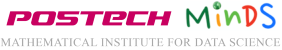

제가 속한 연구실 MINDS 에서는 TDA와 같은 인공지능 뿐만 아니라 다양한 수리적 모델을 응용한 인공지능을 연구하고 있습니다.

http://minds.postech.ac.kr/ (포항공대 수리과학관 2층 212호)

MINDS는 항상 열려있습니다! 

관심있는 여러분의 방문을 기다리고 있습니다!

#THANK YOU FOR LISTENING
\

## Reference 

[1] giotto-tda: A Topological Data Analysis Toolkit for Machine Learning and Data Exploration, Tauzin et al, arXiv:2004.02551, 2020.

[2] Garin, Adélie, and Guillaume Tauzin. "A Topological" Reading" Lesson: Classification of MNIST using TDA." 2019 18th IEEE International Conference On Machine Learning And Applications (ICMLA). IEEE, 2019.

[3] Edelsbrunner, Herbert, and John Harer. Computational topology: an introduction. American Mathematical Soc., 2010.

[4] Figure(1) : Topological Data Analysis and Persistent Homology by Eric Bunch https://eric-bunch.github.io/blog/topological-data-analysis-and-persistent-homology

[5] Figure (2) : towardsdatascience.com/persistent-homology-with-examples-1974d4b9c3d0.
